<a href="https://www.kaggle.com/code/vincentokumu/dry-eye-disease-modeling?scriptVersionId=224304202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns


# Data Import

In [2]:
#Importing data
data = pd.read_csv(r"/kaggle/input/dry-eye-disease/Dry_Eye_Dataset.csv") #reads in data
data.head() #calls glimpse of data frame


,Gender,Age,Sleep duration,Sleep quality,Stress level,Blood pressure,Heart rate,Daily steps,Physical activity,Height,...,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease
0,F,24,9.5,2,1,137/89,67,3000,31,161,...,N,Y,Y,N,8.7,N,Y,Y,N,Y
1,M,39,9.6,2,3,108/64,60,12000,74,164,...,N,Y,Y,N,9.6,Y,N,N,Y,Y
2,F,45,5.4,1,5,134/81,95,12000,93,179,...,N,N,N,Y,4.0,N,Y,N,N,N
3,F,45,5.4,4,5,110/90,78,19000,32,160,...,N,Y,N,N,7.6,N,Y,N,Y,N
4,F,42,5.7,3,2,99/67,72,4000,173,179,...,N,Y,N,N,3.5,N,Y,Y,N,Y


# Checking for Normality 

None of the variables follow a normal distribution 

In [3]:
#Checking for normality

import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson

# Select only numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Initialize a DataFrame to store results
results = []

for col in numerical_cols:
    try:
        sample_size = len(data[col].dropna())

        if sample_size <= 5000:
            # Use Shapiro-Wilk Test for small samples
            stat, p = shapiro(data[col].dropna())
            test_name = "Shapiro-Wilk"
        else:
            # Use D’Agostino and Pearson’s Test for large samples
            stat, p = normaltest(data[col].dropna())
            test_name = "D'Agostino-Pearson"

        # Store results in a list
        results.append([col, test_name, f"{stat:.4f}", f"{p:.4f}"])
        
    except Exception as e:
        print(f"Error processing {col}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Variable", "Test", "Statistic", "p-value"])

# Pivot table for better display
pivot_table = results_df.pivot(index="Variable", columns="Test", values=["Statistic", "p-value"])

# Fix column formatting
pivot_table.columns = [f"{stat} - {test}" for stat, test in pivot_table.columns]
print(pivot_table)
 

                    Statistic - D'Agostino-Pearson  \
Variable                                             
Age                                     17964.8260   
Average screen time                     18144.4625   
Daily steps                             17409.6397   
Heart rate                              16940.7475   
Height                                  19561.5822   
Physical activity                       17039.0086   
Sleep duration                          16866.9405   
Sleep quality                           68041.1982   
Stress level                            52381.5147   
Weight                                  19114.6235   

                    p-value - D'Agostino-Pearson  
Variable                                          
Age                                       0.0000  
Average screen time                       0.0000  
Daily steps                               0.0000  
Heart rate                                0.0000  
Height                                    0.0

In [4]:
# Convert DED variable from string to numeric, 
# Converts 'Y' to 1 and 'N' to 0

data['Dry Eye Disease'] = data['Dry Eye Disease'].map({'Y': 1, 'N': 0})

# View distribution
print(data['Dry Eye Disease'].value_counts())
print(data['Dry Eye Disease'].value_counts(normalize=True) * 100)

Dry Eye Disease
1    13037
0     6963
Name: count, dtype: int64
Dry Eye Disease
1    65.185
0    34.815
Name: proportion, dtype: float64


# Visualizing the Distributions

This helps inspect the data visualy to ensure the right method is chosen to run the model

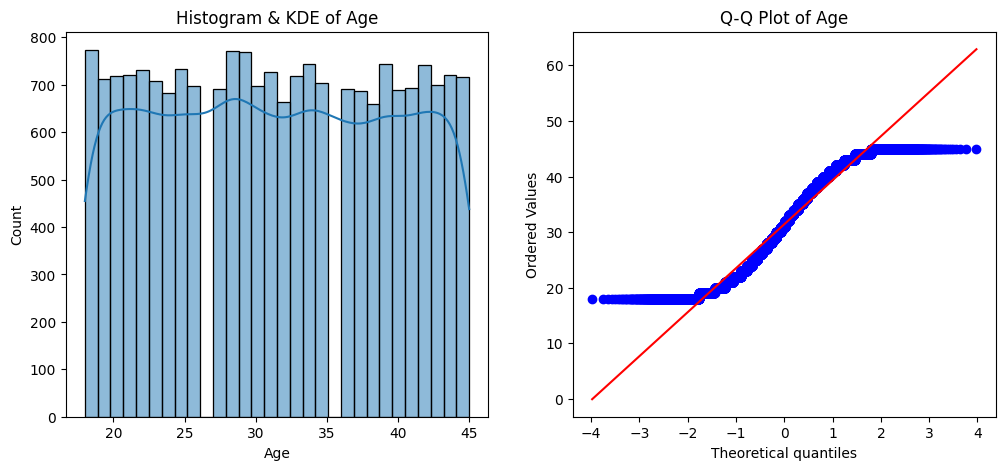

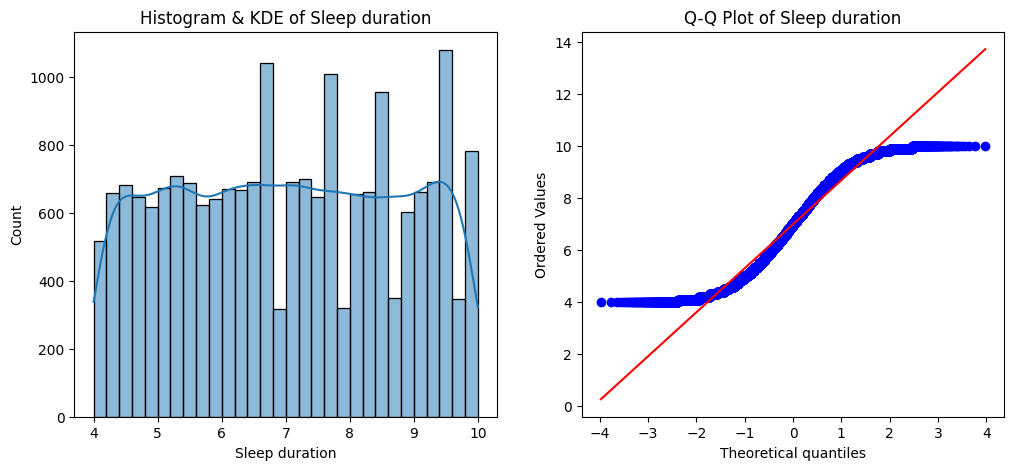

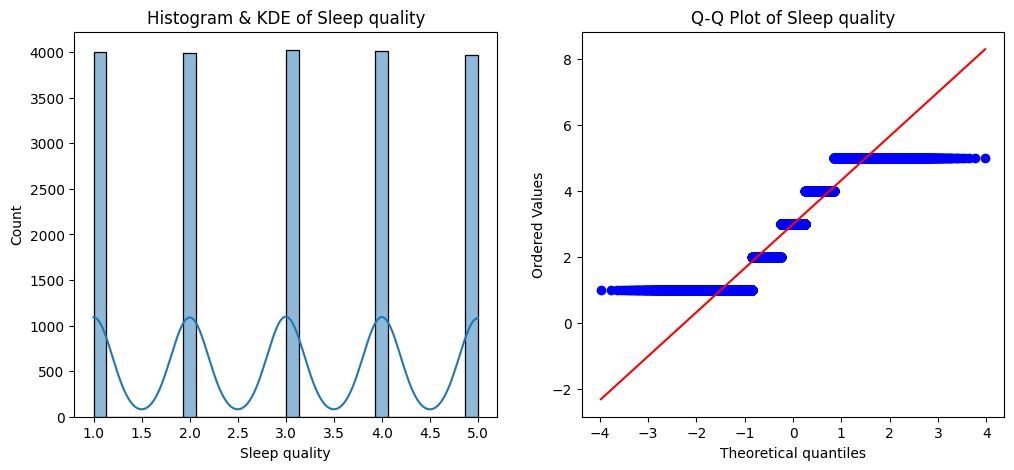

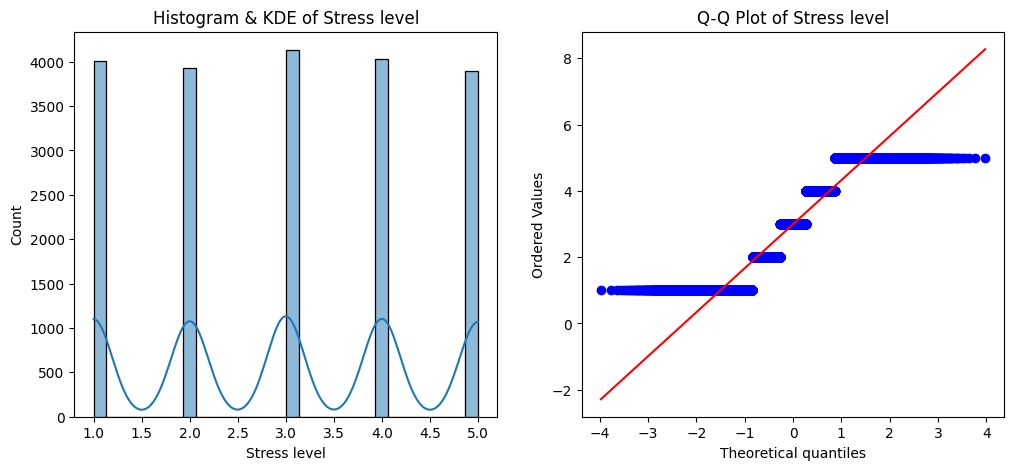

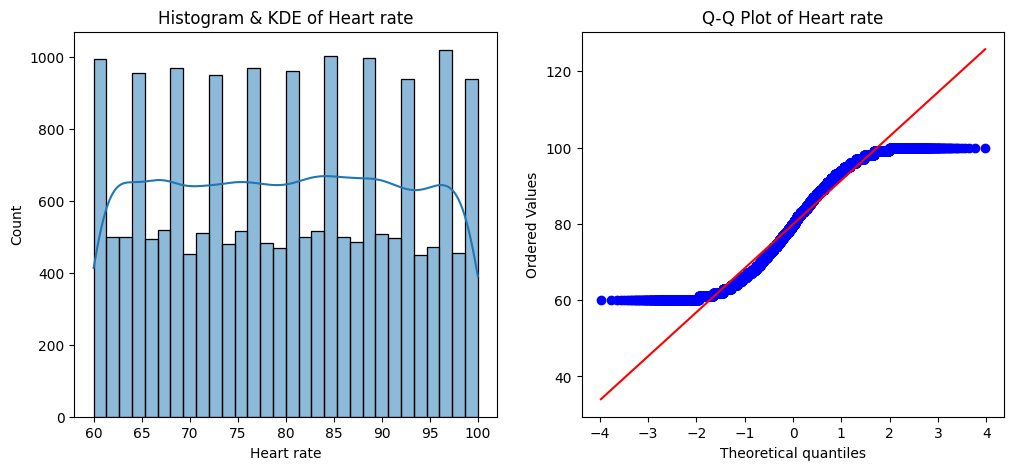

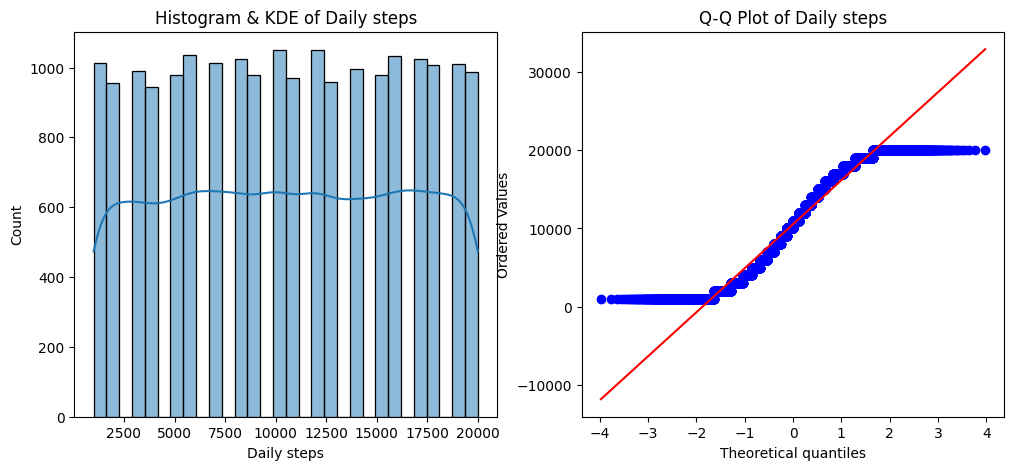

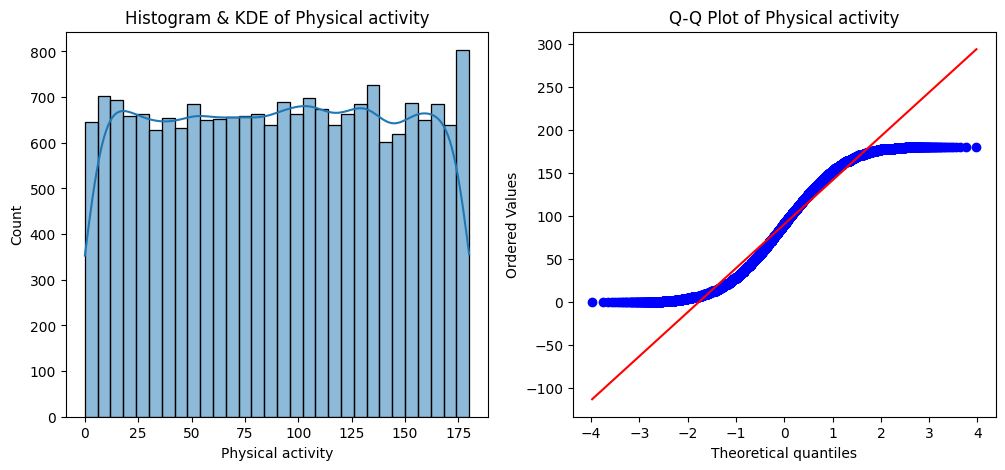

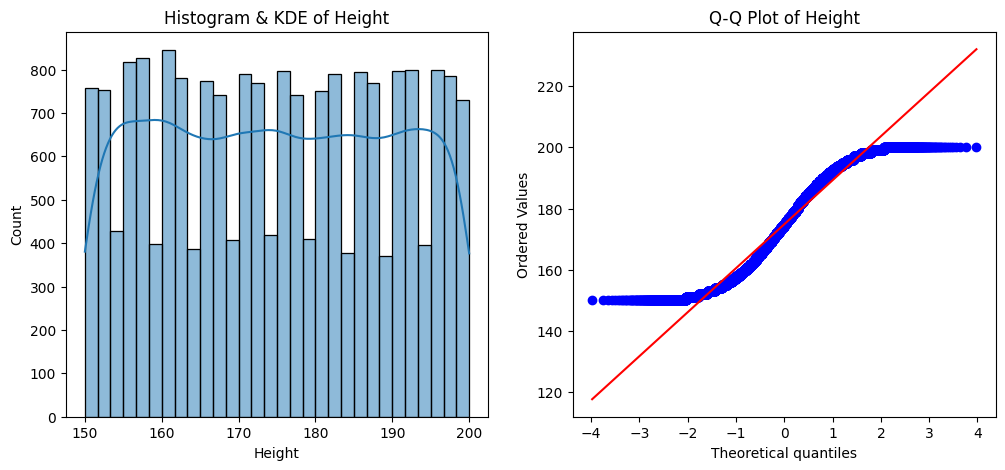

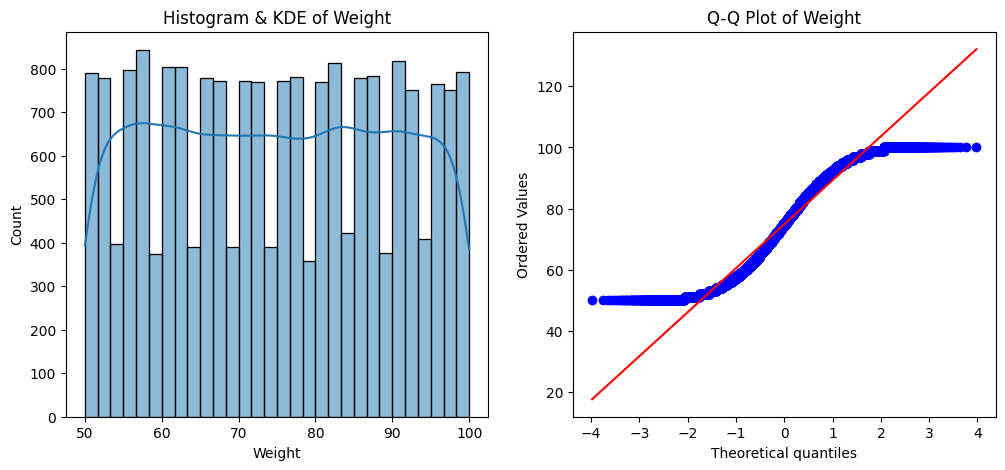

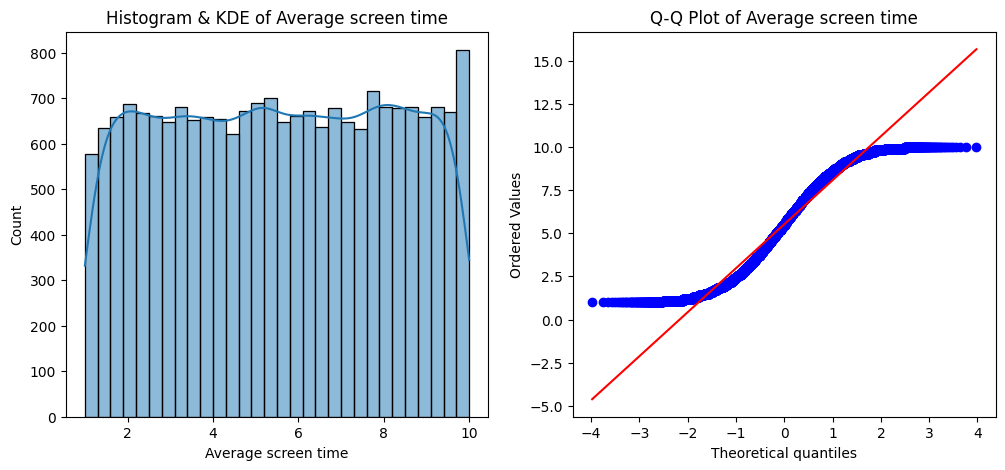

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numerical_cols:
    plt.figure(figsize=(12,5))

    #Histogram and KDE
    plt.subplot(1,2,1)
    sns.histplot(data[col].dropna(),kde=True, bins=30)
    plt.title(f"Histogram & KDE of {col}")

    # Q-Q Plot
    plt.subplot(1,2,2)
    stats.probplot(data[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    
    plt.show()
    

# Random Forest and Decision Tree Models

Since the variables don't assume normality, we test decision tree and random forest models to predict incidence of Dry Eye Disease

In [6]:
#Random Forest - Feature importance based on Gini/Permutation

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

#Assuming 'X' is the feature matrix, and 'y' is the target variable (DED)
X = data.drop(columns=["Dry Eye Disease"])  
y = data["Dry Eye Disease"]

#Encoding categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoders in case you need to reverse the transformation later

# Choose model type
if y.nunique() > 2:  # Regression
    model = RandomForestRegressor(n_estimators=100, random_state=42)
else:  # Classification
    model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
model.fit(X, y)

# Get feature importance
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importances.head(10))  # Show top 10 important variables

                Feature  Importance
5        Blood pressure    0.091107
8     Physical activity    0.087047
20  Average screen time    0.081603
2        Sleep duration    0.078275
10               Weight    0.076744
9                Height    0.076424
6            Heart rate    0.074340
1                   Age    0.068982
7           Daily steps    0.063089
4          Stress level    0.035291


In [7]:
# Decision tree with recursive feature elimination

from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Assuming 'X' is the feature matrix, and 'y' is the target variable
X = data.drop(columns=["Dry Eye Disease"])  
y = data["Dry Eye Disease"]

#Encoding categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoders in case you need to reverse the transformation later

# Choose a Decision Tree model based on the problem type
base_model = DecisionTreeRegressor(random_state=42) if y.nunique() > 2 else DecisionTreeClassifier(random_state=42)

# Apply Recursive Feature Elimination (RFE)
num_features = 10  # Select top 10 features
selector = RFE(base_model, n_features_to_select=num_features)
selector.fit(X, y)

# Get selected feature names
selected_features = X.columns[selector.support_]

# Train a new decision tree model using only the selected features
final_model = DecisionTreeRegressor(random_state=42) if y.nunique() > 2 else DecisionTreeClassifier(random_state=42)
final_model.fit(X[selected_features], y)

# Get feature importance
feature_importance = pd.DataFrame({"Feature": selected_features, 
                                   "Importance": final_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display selected features with importance
print(feature_importance)

               Feature  Importance
3       Blood pressure    0.135940
6    Physical activity    0.130816
8               Weight    0.116393
1       Sleep duration    0.112126
9  Average screen time    0.108022
4           Heart rate    0.096566
7               Height    0.088025
5          Daily steps    0.086805
0                  Age    0.086472
2        Sleep quality    0.038836


# Model Training

In [8]:
# Training of the model
X = data.drop(columns=["Dry Eye Disease"])  # Replace "target" with your actual dependent variable
y = data["Dry Eye Disease"]

#Encoding categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoders in case you need to reverse the transformation later

# Choose a Decision Tree model
base_model = DecisionTreeRegressor(random_state=42) if y.nunique() > 2 else DecisionTreeClassifier(random_state=42)

# Select top features using RFE
num_features = 10  # Adjust as needed
selector = RFE(base_model, n_features_to_select=num_features)
selector.fit(X, y)

# Get selected feature names
selected_features = X.columns[selector.support_]

# Train final model with selected features
final_model = DecisionTreeRegressor(random_state=42) if y.nunique() > 2 else DecisionTreeClassifier(random_state=42)
final_model.fit(X[selected_features], y)

DecisionTreeClassifier(random_state=42)

# Model Visualization

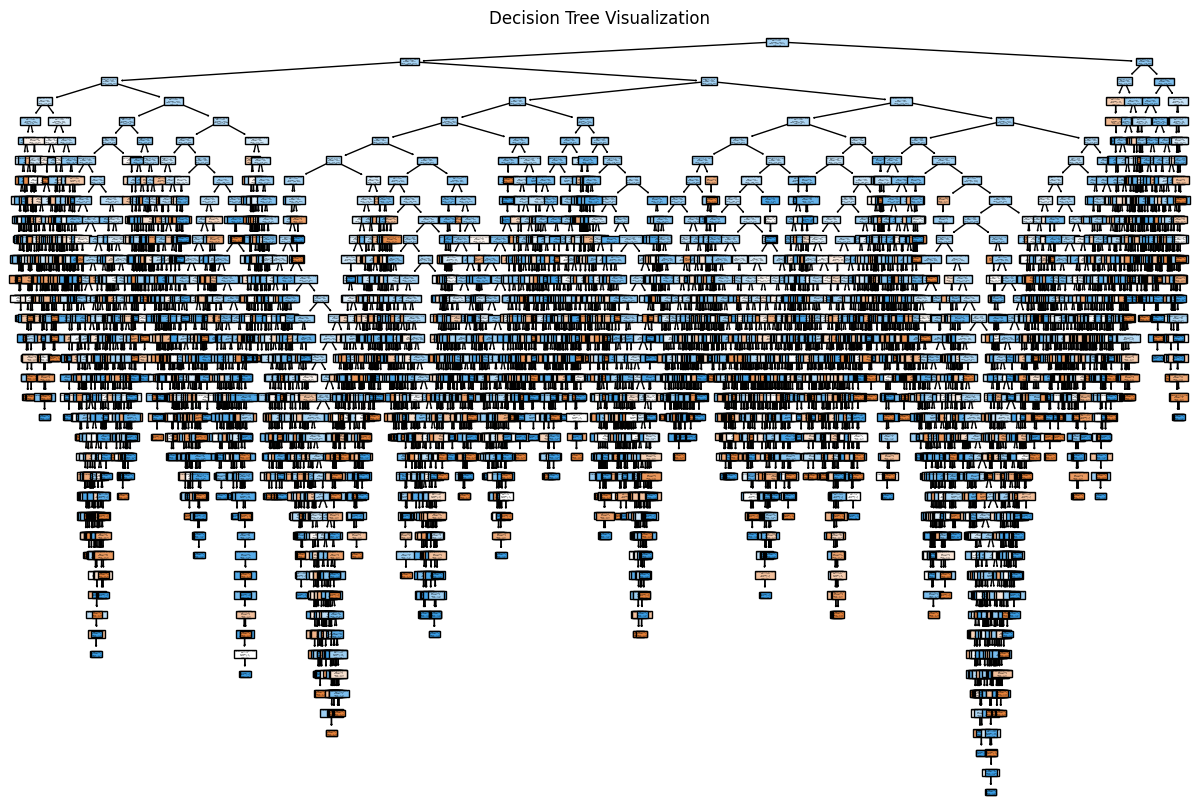

In [9]:
# Visualizing the Decision Tree Model

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(final_model, feature_names=selected_features, class_names=["No", "Yes"] if y.nunique() == 2 else None, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

# Predicting Dry Eye Disease

From the decision tree model developed, we can now predict incidence of dry eye disease using the 10 features earlier identified to best fit the predictive model

In [10]:
# Predicting incidence of Dry Eye Disease

def predict_incidence(model, input_data):
    """
    Predict the dependent variable given input values for selected features.
    
    Parameters:
    - model: Trained Decision Tree model
    - input_data: Dictionary with feature values, e.g., {"Age": 30, "Sleep duration": 5, ...}
    
    Returns:
    - Predicted class or value
    """
    # Convert input dictionary to a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Ensure it contains only the selected features
    input_df = input_df[selected_features]
    
    # Make prediction
    prediction = model.predict(input_df)[0]
    
    return prediction

# Model test
example_input = {"Age": 40, "Sleep duration": 5, "Sleep quality": 2, "Blood pressure": 168/89, "Heart rate": 87, "Daily steps": 2000, "Physical activity": 32, "Height": 150, "Weight": 102, "Average screen time": 10.7}
predicted_value = predict_incidence(final_model, example_input)
print("Predicted Outcome:", predicted_value)

Predicted Outcome: 1
